In [18]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [13]:

DATASETS = {
    "big_mac": {
        "mid":   ("X_features_fed_funds_mid_big_mac.csv",   "y_target_fed_funds_mid_big_mac.csv"),
        "lower": ("X_features_fed_funds_lower_big_mac.csv", "y_target_fed_funds_lower_big_mac.csv"),
        "upper": ("X_features_fed_funds_upper_big_mac.csv", "y_target_fed_funds_upper_big_mac.csv"),
    },
    "no_big_mac": {
        "mid":   ("X_features_fed_funds_mid_no_big_mac.csv",   "y_target_fed_funds_mid_no_big_mac.csv"),
        "lower": ("X_features_fed_funds_lower_no_big_mac.csv", "y_target_fed_funds_lower_no_big_mac.csv"),
        "upper": ("X_features_fed_funds_upper_no_big_mac.csv", "y_target_fed_funds_upper_no_big_mac.csv"),
    }
}


# SELECT FEATURE SET
USE_BIG_MAC = True         # True = Big Mac engineered set, False = FRED-only
TARGET_VERSION = "mid"     # "mid", "lower", or "upper"

subset = "big_mac" if USE_BIG_MAC else "no_big_mac"

X_file, y_file = DATASETS[subset][TARGET_VERSION]

print("Using X file:", X_file)
print("Using y file:", y_file)


# LOAD DATA
X = pd.read_csv(f"data/{X_file}", index_col=0, parse_dates=True)
y = pd.read_csv(f"data/{y_file}", index_col=0, parse_dates=True).iloc[:, 0]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Start:", X.index.min(), "| End:", X.index.max())


Using X file: X_features_fed_funds_mid_big_mac.csv
Using y file: y_target_fed_funds_mid_big_mac.csv
X shape: (286, 80)
y shape: (286,)
Start: 2001-04-30 00:00:00 | End: 2025-01-31 00:00:00


In [14]:
# Chronological split
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [20]:
baseline_pred = np.full(len(y_test), y_train.mean(), dtype=float)
baseline_pred_persist = np.full(len(y_test), y_train.iloc[-1], dtype=float)

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

print("Mean baseline:", evaluate(y_test, baseline_pred))
print("Persistence baseline:", evaluate(y_test, baseline_pred_persist))


Mean baseline: {'MAE': 2.3247504537205077, 'RMSE': 2.6110424877699105, 'R2': -0.2395699987606088}
Persistence baseline: {'MAE': 2.5086206896551726, 'RMSE': 3.434108828834034, 'R2': -1.1442295999027117}


c:\Users\schmi\OneDrive\Documents\Final345\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+00, tolerance: 5.731e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\schmi\OneDrive\Documents\Final345\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e+00, tolerance: 5.731e-02
  model = cd_fast.enet_coordinate_descent(


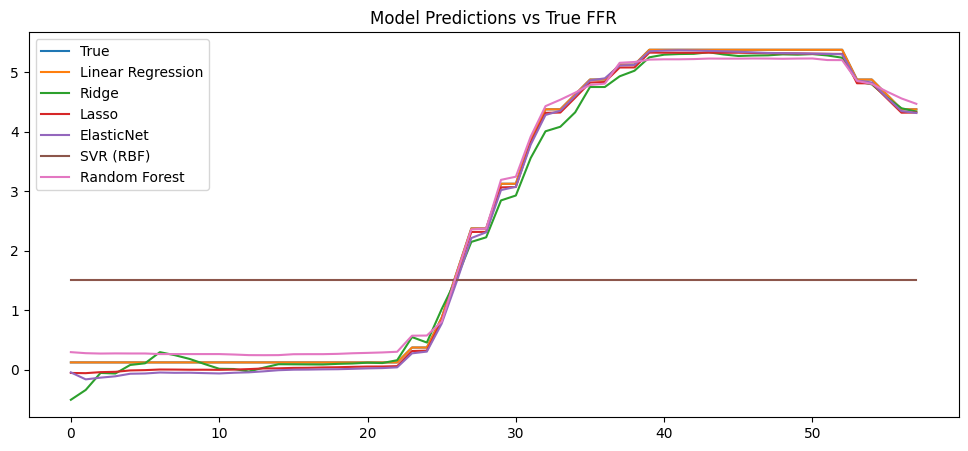

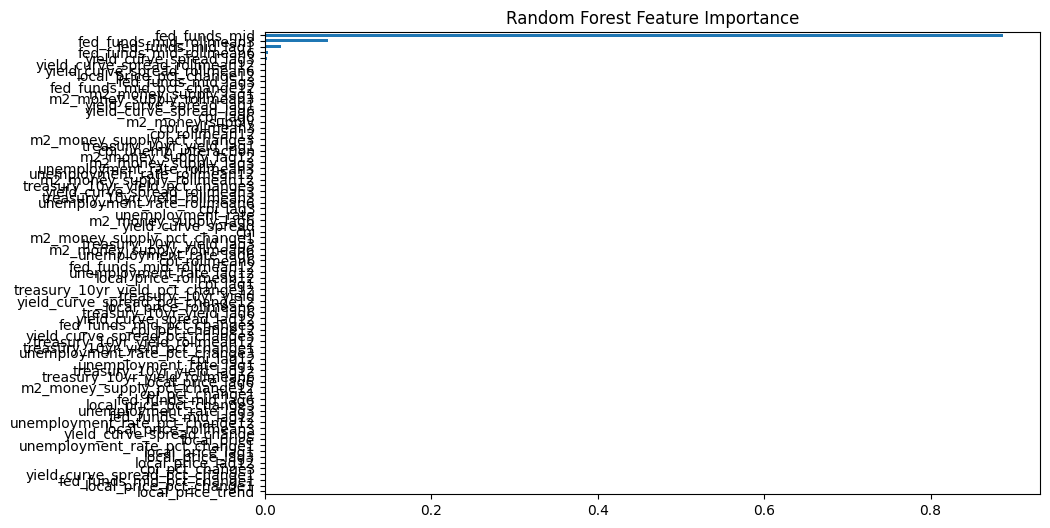

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "SVR (RBF)": SVR(kernel="rbf", C=10, gamma=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = evaluate(y_test, preds)

pd.DataFrame(results).T

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="True")

for name, model in models.items():
    pred = model.predict(X_test)
    plt.plot(pred, label=name)

plt.legend()
plt.title("Model Predictions vs True FFR")
plt.show()

rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(10,6))
plt.title("Random Forest Feature Importance")
plt.show()

pd.DataFrame(results).T.to_csv("model_performance.csv")